# HW 6
## In this assignment we will be performing aperture photometry

In [1]:
# import block
# some of these may not be needed
import numpy as np
from astropy.io import fits
import pdb
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rc
import matplotlib
from astropy.visualization import hist
from datetime import datetime
from pathlib import Path
import os
from ccdproc import ImageFileCollection
import ccdproc as ccdp
from astropy.modeling.models import Polynomial1D,Chebyshev1D,Legendre1D,Hermite1D, Gaussian1D,Gaussian2D,Polynomial2D
from astropy.modeling import fitting
from astropy.stats import mad_std
from astropy.nddata import CCDData, StdDevUncertainty
from scipy import stats
from astropy import units as u
from photutils.aperture import CircularAperture,CircularAnnulus
from photutils.aperture import aperture_photometry
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
from astropy.table import Table

from astropy.coordinates import SkyCoord

In [2]:
# import convenience plotting functions downloaded from 
# here: https://github.com/mwcraig/ccd-reduction-and-photometry-guide
phot_tutorial_dir = '/Users/azeem/Downloads/Software/py/ccd-reduction-and-photometry-guide/ccd-reduction-and-photometry-guide/notebooks/'
import sys
sys.path.insert(0,phot_tutorial_dir)
from convenience_functions import show_image

In [3]:
# for imaging, I like the photometry notebook plot defaults
# so use their custom style for larger fonts and figures
plt.style.use('/Users/azeem/Downloads/Software/py/ccd-reduction-and-photometry-guide/ccd-reduction-and-photometry-guide/notebooks/guide.mplstyle')

# set a couple more default parameters for the plots below
rc('font', size=20)
rc('axes', grid=True)

In [203]:
data_dir = '/Users/azeem/Downloads/Imaging/'
reduced_dir = '/Users/azeem/Downloads/Reduced/otzf/'

# Problem 1
Testing the linearity of the CCD. First, we read in the linearity test files

In [6]:
lin_test = np.arange(74,81)
# list comprehension
names = ['a'+str(num).zfill(3)+'.fits' for num in lin_test]
print(names)

['a074.fits', 'a075.fits', 'a076.fits', 'a077.fits', 'a078.fits', 'a079.fits', 'a080.fits']


Since we want to focus on a saturated star, we read in the frame with the longest exposure time

In [56]:
hdu = fits.open(data_dir+names[6])
hdr = hdu[0].header
data = hdu[0].data
print(hdr)

SIMPLE  =                    T / Fits standard                                  BITPIX  =                   16 / Bits per pixel                                 NAXIS   =                    2 / Number of axes                                 NAXIS1  =                 2200 / Axis length                                    NAXIS2  =                 2048 / Axis length                                    EXTEND  =                    F / File may contain extensions                    BSCALE  =           1.000000E0 / REAL = TAPE*BSCALE + BZERO                     BZERO   =           3.276800E4 /                                                ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        DATE    = '2009-09-15T15:56:29' / Date FITS file was generated                  IRAF-TLM= '09:56:28 (15/09/2009)' / Time of last modification                   DATAMIN =           0.000000E0 / Minimum data value                             DATAMAX =           6.553500E4 / Maximum

Now we display and crop the image to the area of interest, the saturated star

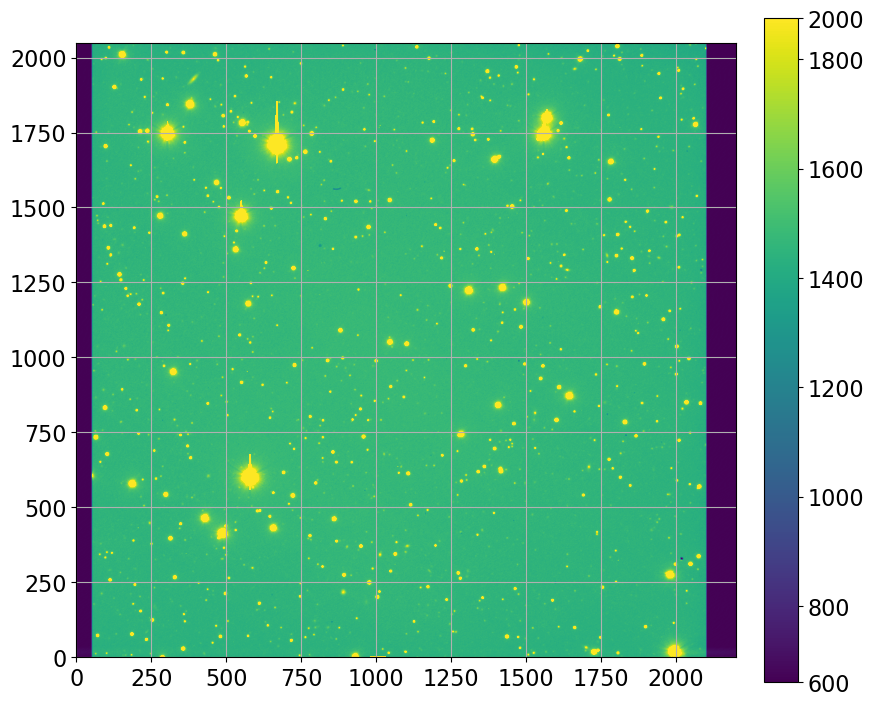

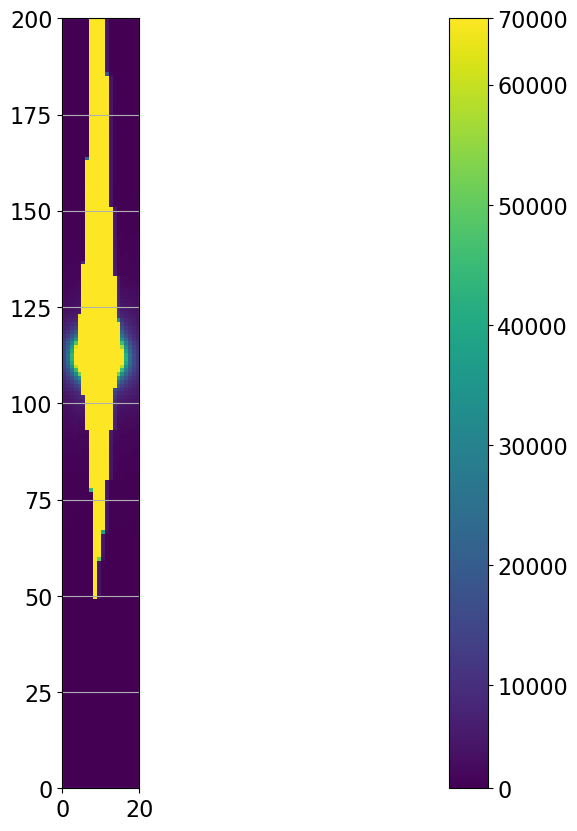

In [59]:
show_image(data)
sat_image = data[1600:1800,660:680]
show_image(sat_image)

And we find the mean number of counts

In [38]:
mean1 = np.mean(sat_image)
print(mean1)

5256.776666666667


We now do this over all 6 tests and plot counts vs exposures

1019.2
1429.2666666666667
3003.6
26378.133333333335
50916.8
54929.86666666667
54398.73333333333


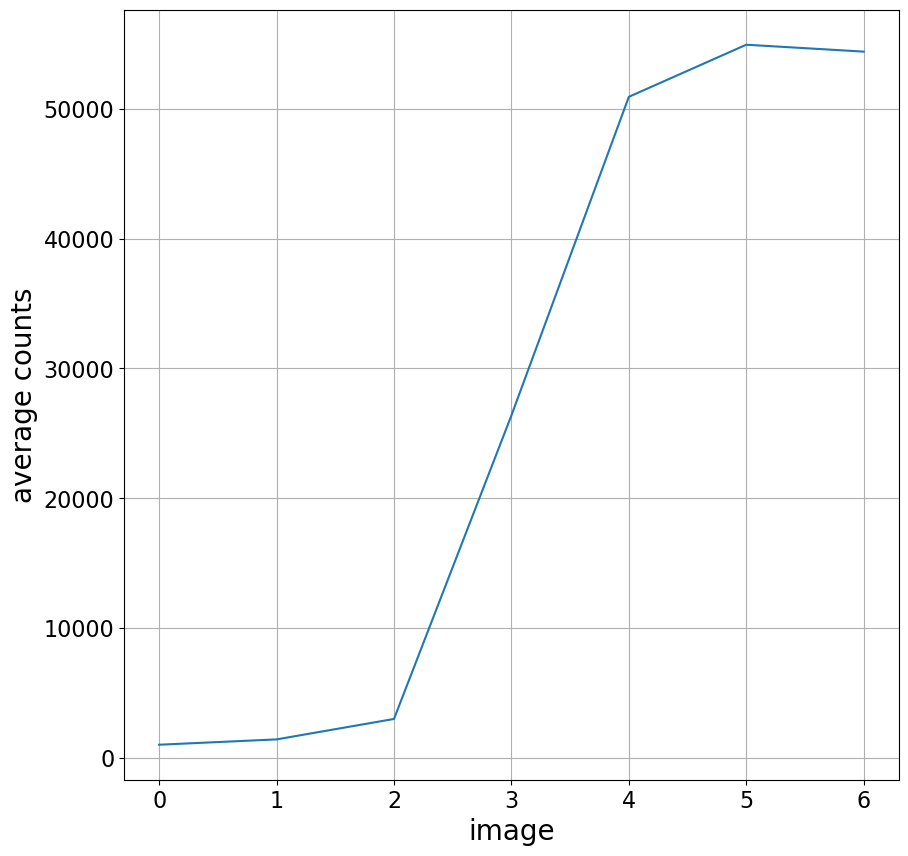

In [78]:
means = []
for i in np.arange(0,7):
    hdu = fits.open(data_dir+names[i])
    data = hdu[0].data
    sat_image = data[1705:1725,665:680]
    mean = np.mean(sat_image[i])
    print(mean)
    means = np.append(means, mean)
plt.plot(means)
plt.ylabel('average counts')
plt.xlabel('image')
plt.show()

As we can see, the number of counts tends to go up linearly until longer exposure times, where it begins to plateau near the ADU limit

# Problem 2
We now want to perform aperture photometry on the non-standard stars in the PG1633+099 field

In [75]:
#read in frame
hdupg = fits.open(reduced_dir+'a085ot.fits')
hdrpg = hdupg[0].header
datapg = hdupg[0].data
print(hdrpg)

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 2048                                                  NAXIS2  =                 2048                                                  ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        DATE    = '2009-09-15T15:56:29' / Date FITS file was generated                  IRAF-TLM= '09:56:29 (15/09/2009)' / Time of last modification                   DATAMIN =           0.000000E0 / Minimum data value                             DATAMAX =           2.923200E4 / Maximum data value                             OBJECT  = 'pg1633  '           / Name of the object observed                    DATE-OBS= '2009-06-23T04:03:02.000' / Date and time of observation              TIMESYS = 'UTC     ' / Default time syst

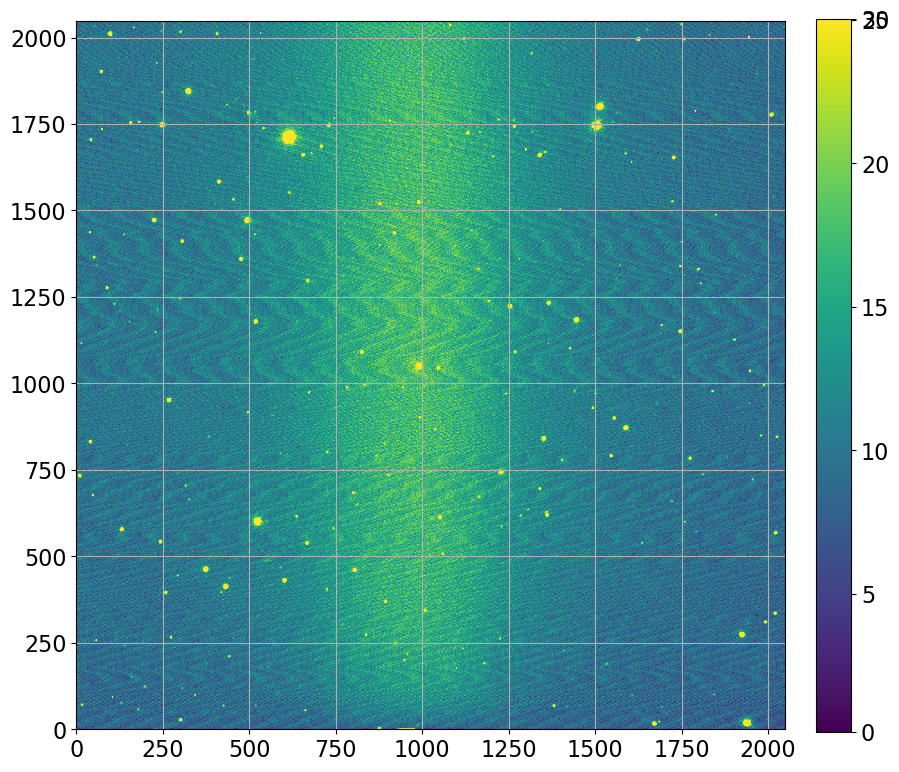

In [76]:
show_image(datapg)

Using DS9, I picked 3 stars: one faint, one medium brightness, and one very bright

In [79]:
mediumx1 = 602.91067
mediumy1 = 430.06252

faintx1 = 637.45926
fainty1 = 614.49053

brightx1 = 1504.3291
brighty1 = 1744.2306

faintposition = [(faintx1,fainty1)]
mediumposition = [(mediumx1,mediumy1)]
brightposition = [(brightx1,brighty1)]

We now test 5 different aperture sizes for each star

In [128]:
from photutils.aperture import CircularAnnulus, CircularAperture
aperture1 = CircularAperture(faintposition, r=1)
aperture2 = CircularAperture(faintposition, r=3)
aperture3 = CircularAperture(faintposition, r=5)
aperture4 = CircularAperture(faintposition, r=7)
aperture5 = CircularAperture(faintposition, r=10)
apertures = [aperture1, aperture2, aperture3, aperture4, aperture5]

aperturemed1 = CircularAperture(mediumposition, r=1)
aperturemed2 = CircularAperture(mediumposition, r=3)
aperturemed3 = CircularAperture(mediumposition, r=5)
aperturemed4 = CircularAperture(mediumposition, r=7)
aperturemed5 = CircularAperture(mediumposition, r=15)
aperturesmed = [aperturemed1, aperturemed2, aperturemed3, aperturemed4, aperturemed5]

aperturebright1 = CircularAperture(brightposition, r=1)
aperturebright2 = CircularAperture(brightposition, r=3)
aperturebright3 = CircularAperture(brightposition, r=5)
aperturebright4 = CircularAperture(brightposition, r=7)
aperturebright5 = CircularAperture(brightposition, r=10)
aperturesbright = [aperturebright1, aperturebright2, aperturebright3, aperturebright4, aperturebright5]

annulus_aperture = CircularAnnulus(faintposition, r_in=10, r_out=15)
annulus_aperturemed = CircularAnnulus(mediumposition, r_in=10, r_out=15)
annulus_aperturebright = CircularAnnulus(brightposition, r_in=10, r_out=15)

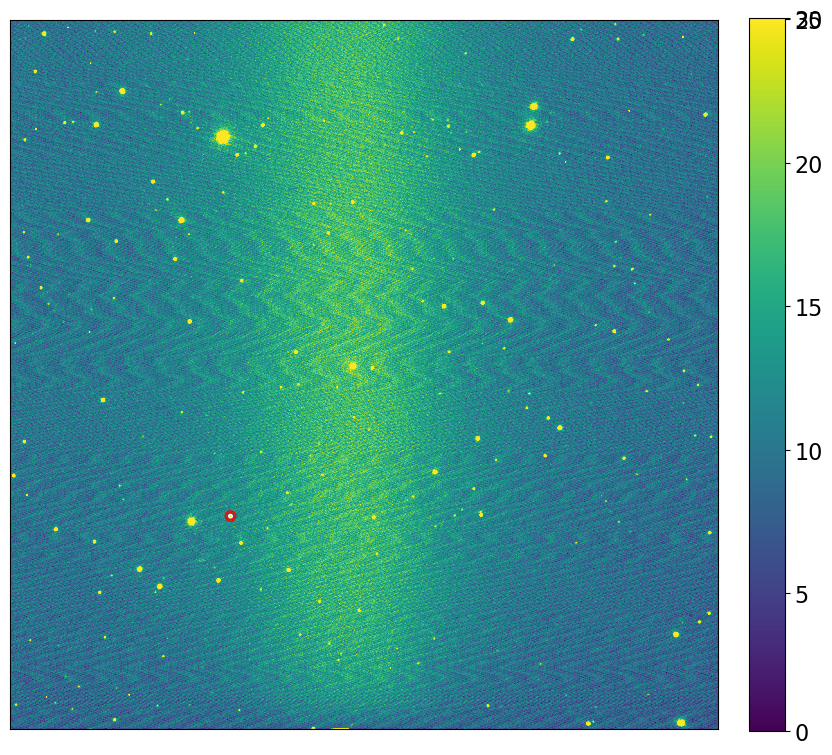

In [124]:
show_image(datapg)
plt.xticks([])
plt.yticks([])
plt.grid(False)
aperture.plot(color='w')
annulus_aperture.plot(color='r')
plt.show()

# Faint Star
We use photutils to calculate the SNR of the star using the equation S/N = S/sqrt(area*B). Then plot SNR vs aperture size to gauge what the best aperture size to use is. Repeat for the medium and bright stars

 id  xcenter   ycenter  aperture_sum
       pix       pix                
--- --------- --------- ------------
  1 637.45926 614.49053    169.80492
3.141592653589793
aperture_sum
------------
   10.370917
 id  xcenter   ycenter  aperture_sum
       pix       pix                
--- --------- --------- ------------
  1 637.45926 614.49053    1008.7031
28.274333882308138
aperture_sum
------------
   51.994896
 id  xcenter   ycenter  aperture_sum
       pix       pix                
--- --------- --------- ------------
  1 637.45926 614.49053    1980.5711
78.53981633974483
aperture_sum
------------
    79.06743
 id  xcenter   ycenter  aperture_sum
       pix       pix                
--- --------- --------- ------------
  1 637.45926 614.49053    3013.9487
153.93804002589985
aperture_sum
------------
   85.901952
 id  xcenter   ycenter  aperture_sum
       pix       pix                
--- --------- --------- ------------
  1 637.45926 614.49053    4964.0504
314.1592653589793
aperture_sum

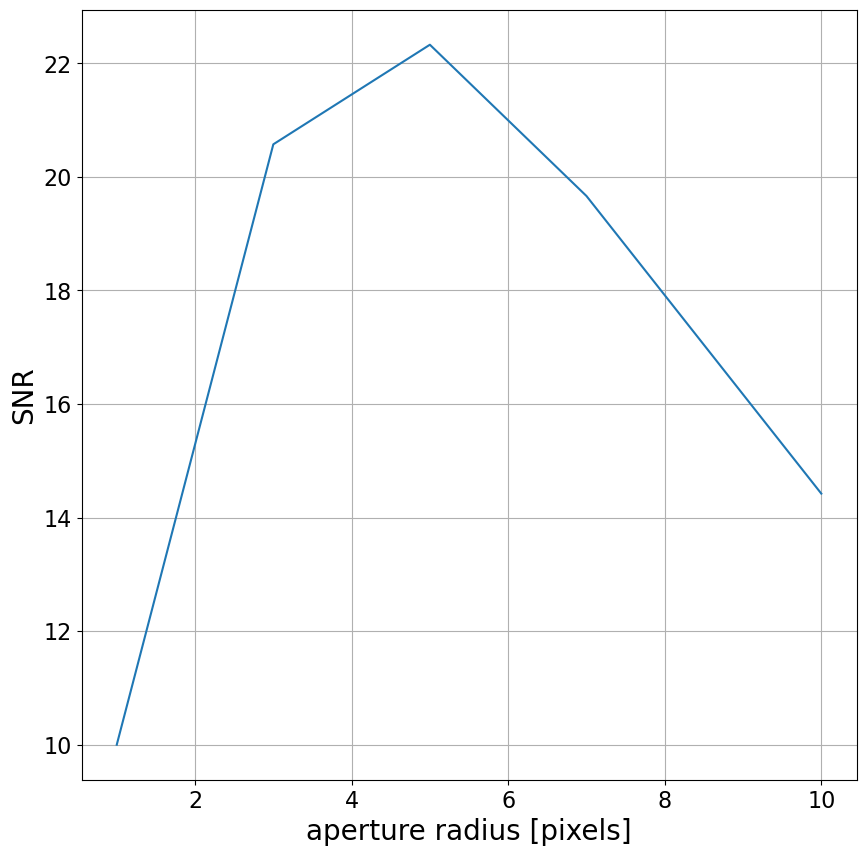

In [508]:
import numpy as np
from photutils.aperture import aperture_photometry
snrfaints = []
for i in np.arange(0,5):
    phot_table = aperture_photometry(datapg, apertures[i])
    phot_table['aperture_sum'].info.format = '%.8g'  # for consistent table output
    print(phot_table)
    T = phot_table['aperture_sum'] #total counts in circular aperture
    #print(T)
    phot_table2 = aperture_photometry(datapg, annulus_aperture)
    phot_table2['aperture_sum'].info.format = '%.8g'  # for consistent table output
    #print(phot_table2)
    r = [1, 3, 5, 7, 10]
    area = np.pi * r[i]**2 #area of circular aperture
    print(area)
    areaannulus = np.pi*(15**2 - 10**2)
    annuluscount = phot_table2['aperture_sum']
    B = annuluscount/areaannulus
    S = T - area*B
    snr = S/B
    snr2 = S/np.sqrt(S+(area*B))
    print(snr)
    snrfaints = np.append(snrfaints, snr2)
plt.plot(r,snrfaints)
plt.ylabel('SNR')
plt.xlabel('aperture radius [pixels]')
plt.show()

## Medium Star

 id  xcenter   ycenter  aperture_sum
       pix       pix                
--- --------- --------- ------------
  1 602.91067 430.06252    1221.5041
3.141592653589793
aperture_sum
------------
   80.863325
aperture_sum
------------
   100.45986
 id  xcenter   ycenter  aperture_sum
       pix       pix                
--- --------- --------- ------------
  1 602.91067 430.06252    7846.5831
28.274333882308138
aperture_sum
------------
   80.863325
aperture_sum
------------
   637.23094
 id  xcenter   ycenter  aperture_sum
       pix       pix                
--- --------- --------- ------------
  1 602.91067 430.06252    12564.045
78.53981633974483
aperture_sum
------------
   80.863325
aperture_sum
------------
   987.07539
 id  xcenter   ycenter  aperture_sum
       pix       pix                
--- --------- --------- ------------
  1 602.91067 430.06252    14649.444
153.93804002589985
aperture_sum
------------
   80.863325
aperture_sum
------------
   1088.5495
 id  xcenter   ycenter

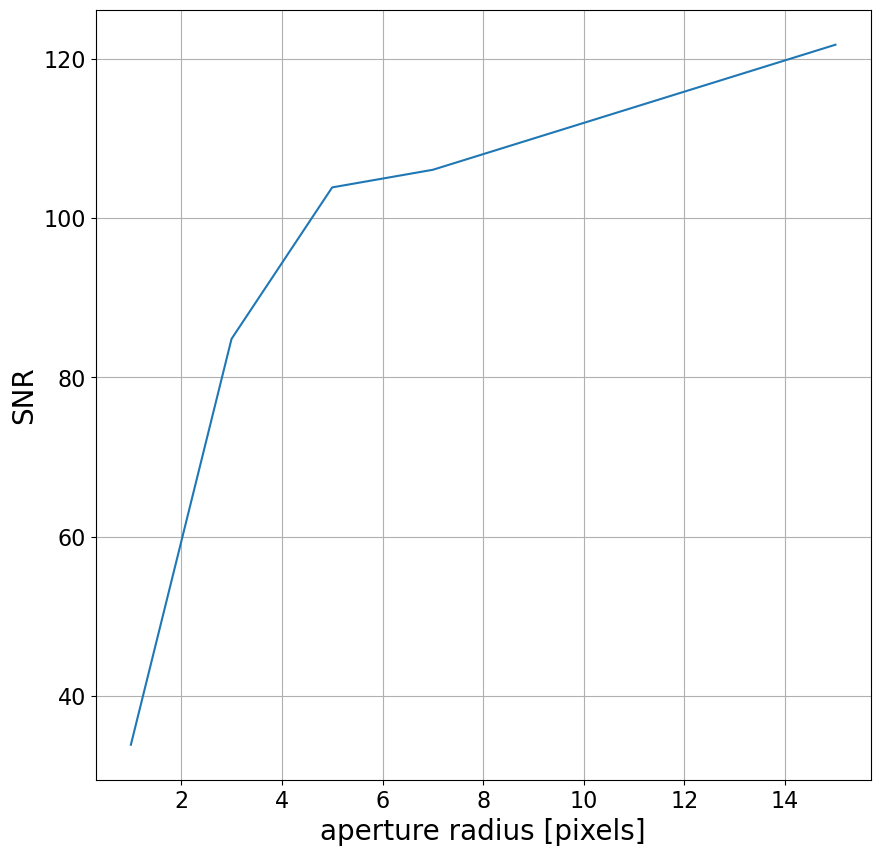

In [509]:
snrmeds = []
for i in np.arange(0,5):
    phot_tablemed = aperture_photometry(datapg, aperturesmed[i])
    phot_tablemed['aperture_sum'].info.format = '%.8g'  # for consistent table output
    print(phot_tablemed)
    Tmed = phot_tablemed['aperture_sum'] #total counts in circular aperture
    #print(T)
    phot_table2med = aperture_photometry(datapg, annulus_aperturemed)
    phot_table2med['aperture_sum'].info.format = '%.8g'  # for consistent table output
    #print(phot_table2)
    rmed = [1, 3, 5, 7, 15]
    area = np.pi * r[i]**2 #area of circular aperture
    print(area)
    areaannulus = np.pi*(15**2 - 10**2)
    #print(areaannulus)
    annuluscountmed = phot_table2med['aperture_sum']
    Bmed = annuluscountmed/areaannulus
    #print(B1)
    Smed = Tmed - area*Bmed
    snr3 = Smed/np.sqrt(Smed+(area*Bmed))
    print(snr)
    snrmed = Smed/Bmed
    print(snrmed)
    snrmeds = np.append(snrmeds, snr3)
plt.plot(rmed,snrmeds)
plt.ylabel('SNR')
plt.xlabel('aperture radius [pixels]')
plt.show()

## Bright Star

 id  xcenter   ycenter  aperture_sum
       pix       pix                
--- --------- --------- ------------
  1 1504.3291 1744.2306    23721.229
3.141592653589793
aperture_sum
------------
   969.17245
 id  xcenter   ycenter  aperture_sum
       pix       pix                
--- --------- --------- ------------
  1 1504.3291 1744.2306    139654.62
28.274333882308138
aperture_sum
------------
   5696.0557
 id  xcenter   ycenter  aperture_sum
       pix       pix                
--- --------- --------- ------------
  1 1504.3291 1744.2306    211033.26
78.53981633974483
aperture_sum
------------
   8571.5434
 id  xcenter   ycenter  aperture_sum
       pix       pix                
--- --------- --------- ------------
  1 1504.3291 1744.2306    234379.75
153.93804002589985
aperture_sum
------------
   9453.0988
 id  xcenter   ycenter  aperture_sum
       pix       pix                
--- --------- --------- ------------
  1 1504.3291 1744.2306    245182.56
314.1592653589793
aperture_sum

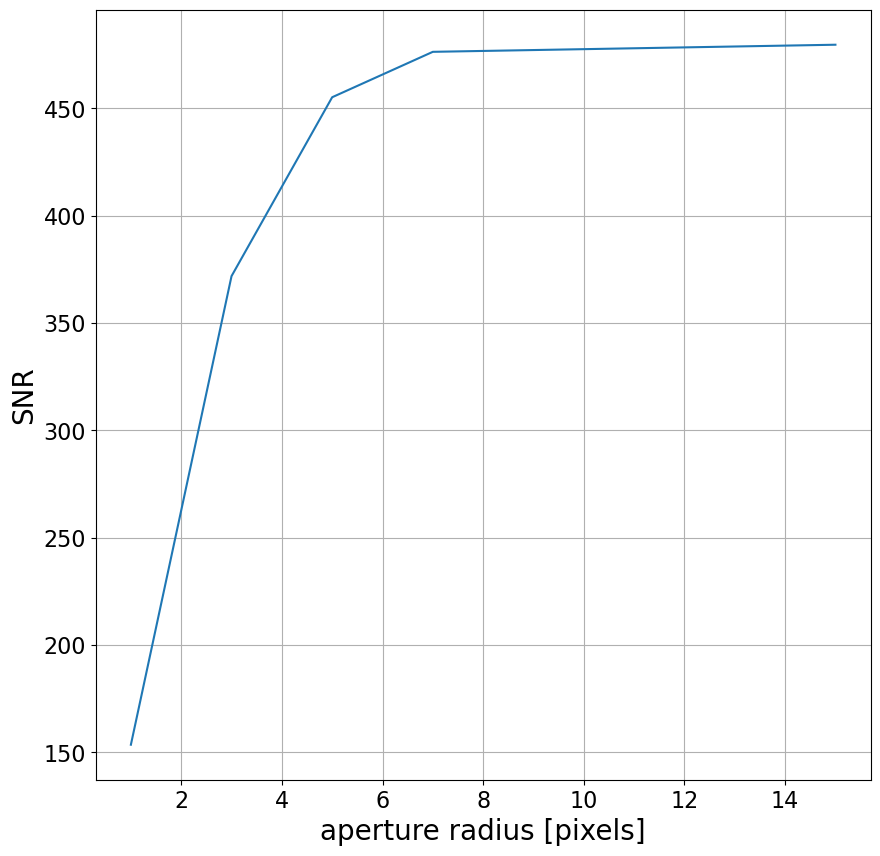

In [510]:
snrbrights = []
for i in np.arange(0,5):
    phot_tablebright = aperture_photometry(datapg, aperturesbright[i])
    phot_tablebright['aperture_sum'].info.format = '%.8g'  # for consistent table output
    print(phot_tablebright)
    Tbright = phot_tablebright['aperture_sum'] #total counts in circular aperture
    #print(T)
    phot_table2bright = aperture_photometry(datapg, annulus_aperturebright)
    phot_table2bright['aperture_sum'].info.format = '%.8g'  # for consistent table output
    #print(phot_table2)
    rbright = [1, 3, 5, 7, 15]
    area = np.pi * r[i]**2 #area of circular aperture
    print(area)
    areaannulus = np.pi*(15**2 - 10**2)
    #print(areaannulus)
    annuluscountbright = phot_table2bright['aperture_sum']
    Bbright = annuluscountbright/areaannulus
    #print(B1)
    Sbright = Tbright - area*Bbright
    #print(S)
    snr4 = Sbright/np.sqrt(Sbright+(area*Bbright))
    snrbright = Sbright/Bbright
    print(snrbright)
    snrbrights = np.append(snrbrights, snr4)
plt.plot(rbright,snrbrights)
plt.ylabel('SNR')
plt.xlabel('aperture radius [pixels]')
plt.show()

Overall, my plots look decent, however they don't exactly come back down as the aperture radius increases. This could be due to an error in my S/N calculation or I need larger aperture radii. For this data set, I will use an aperture size of 5 pixels

# Problem 3
To identify the standard stars in the field, I used the frame found in Landolt (1992) and cross-matched their positions

In [301]:
#3 using Landolt paper, cross-match standard stars using DS9 positions
starA = [(1047.3949,1042.4182)]
starB = [(1256.4138,1219.089)]
starC = [(1363.4115,1231.5306)]
starD = [(1443.0378,1181.7642)]
starI = [(990.16352,1049.8832)]
standards = [starA,starB,starC,starD,starI]

# Problem 4

Now we want to perform aperture photometry on each of the standard stars, in each frame, in each filter. Then we calculate their magnitudes.

But first, I made a table displaying all of the colors and magnitudes of each standard star from Landolt (1992)

In [275]:
landolt = Table()
landolt['V']   = [14.397,15.256,12.969,13.229,13.691]
landolt['B-V'] = [-0.192,0.837,1.081,1.134,0.535] 
landolt['U-B'] = [-0.874,0.320,1.007,1.138,-0.025]
landolt['V-R'] = [-0.093,0.505,0.590,0.618,0.324]
landolt['R-I'] = [-0.116,0.511,0.502,0.523,0.327]
landolt['V-I'] = [-0.212,1.015,1.090,1.138,0.650]

landolt['B'] = landolt['B-V']+landolt['V']
landolt['U'] = landolt['U-B']+landolt['B']
landolt['R'] = landolt['V']-landolt['V-R']
landolt['I'] = landolt['V']-landolt['V-I']

In [276]:
landolt

<Table length=5>
   V      B-V     U-B   ...         U                  R             I   
float64 float64 float64 ...      float64            float64       float64
------- ------- ------- ... ------------------ ------------------ -------
 14.397  -0.192  -0.874 ...             13.331              14.49  14.609
 15.256   0.837    0.32 ...             16.413             14.751  14.241
 12.969   1.081   1.007 ... 15.056999999999999             12.379  11.879
 13.229   1.134   1.138 ...             15.501 12.610999999999999  12.091
 13.691   0.535  -0.025 ...             14.201             13.367  13.041

In [220]:
science_files = [reduced_dir+'a'+str(i).zfill(3)+'otz.fits' for i in np.arange(173)+81]
del science_files[12:49]
del science_files[22:84]
del science_files[32:57]
del science_files[42:49]
print(len(science_files))

42


In [475]:
pg_dir = '/Users/azeem/Downloads/Reduced/otzf/pg/'

## V-filter

In [315]:
imgs = ccdp.ImageFileCollection(pg_dir,glob_include='*otz.fits')
imgnameV = imgs.files_filtered(filter='V')
print(imgnameV)

['a085otz.fits' 'a086otz.fits' 'a134otz.fits' 'a135otz.fits'
 'a206otz.fits' 'a207otz.fits' 'a241otz.fits' 'a242otz.fits']


I added here the approximate positions of each standard star in each different frame. They are in order from 1, A, B, C, D to match the table in Landolt (1992)

In [366]:
#for V-filter

approx_pos = [[(988.8683,1049.2803),(1044.8029,1043.2159),(1251.6695,1221.4295),(1363.9839,1230.9691),(1444.0144,1182.0372)],\
[(987.9844,1049.2036),(1043.8968,1043.1361),(1250.6889,1221.1958),(1363.0112,1230.7516),(1443.0305,1181.8385)],\
[(931.8118,1043.4529),(987.6939,1037.3564),(1194.6650,1215.5002),(1307.0202,1225.0282),(1386.9956,1176.1044)],\
[(932.0204,1043.5176),(987.9188,1037.3954),(1194.7984,1215.5333),(1307.1397,1225.0323),(1387.0961,1176.0627)],\
[(924.4201,1037.0850),(980.2808,1030.9915),(1187.3280,1208.8491),(1299.5213,1218.2871),(1379.4235,1169.3869)],\
[(925.3480,1036.7100),(981.2349,1030.6284),(1188.1673,1208.4725),(1300.4663,1217.9357),(1380.4332,1168.9797)],\
[(838.3982,1039.8684),(894.1732,1033.8111),(1101.0422,1211.7489),(1213.2663,1221.1237),(1293.3098,1172.1284)],\
[(838.1403,1039.7337),(893.9993,1033.6562),(1100.9368,1211.3933),(1213.1794,1220.8576),(1293.1324,1171.9191)]]
hdu1 = [fits.open(pg_dir+file) for file in imgnameV]
data1 = [item[0].data for item in hdu1]
goodmV = []
for i in np.arange(0,8):
    annulus_aperturestandard = CircularAnnulus(approx_pos[i], r_in=10, r_out=15)
    aperturestandard = CircularAperture(approx_pos[i], r=7)
    phot_table = aperture_photometry(data1[i], aperturestandard) 
    phot_table['aperture_sum'].info.format = '%.8g'  # for consistent table output
    #print(phot_table)
    T = phot_table['aperture_sum'] #total counts in circular aperture
    #print(T)
    phot_table2 = aperture_photometry(data1[i], annulus_aperturestandard)
    phot_table2['aperture_sum'].info.format = '%.8g'  # for consistent table output
    #print(phot_table2)
    area = np.pi * 5**2 #area of circular aperture
    #print(area)
    areaannulus = np.pi*(15**2 - 10**2)
    #print(areaannulus)
    annuluscount = phot_table2['aperture_sum']
    B = annuluscount/areaannulus
    #print(B1)
    S = T - area*B
    #print(S)
    snr = S/B
    snr2 = np.sqrt(S)
    #print(snr2)
    mV = -2.5*np.log10(S)
    print(mV.data)
    mVdata = mV.data
    corrmV = mVdata-[14.347, 15.256, 12.969, 13.229, 13.691]
    goodmV = np.append(goodmV, corrmV)

[-12.94868126 -12.61725625 -14.90280201 -14.674371   -13.96732191]
[-12.94725345 -12.62075925 -14.90334824 -14.67448639 -13.97009414]
[-12.94740557 -12.61734979 -14.91021925 -14.68247466 -13.97756929]
[-12.9505467  -12.61485905 -14.91194853 -14.67719279 -13.97740728]
[-12.9321766  -12.59606378 -14.87692833 -14.65685987 -13.95927269]
[-12.93235697 -12.59741552 -14.87761954 -14.66046444 -13.95636454]
[-12.82375824 -12.49569229 -14.76559134 -14.53553888 -13.82473879]
[-12.81531361 -12.48211905 -14.75027132 -14.52259736 -13.81743604]


## B-filter

In [365]:
imgnameB = imgs.files_filtered(filter='B')
print(imgnameB)
#4 find instrumental magnitudes for stars in each filter
#for V-filter
approx_pos = [[(988.8683,1049.2803),(1044.8029,1043.2159),(1251.6695,1221.4295),(1363.9839,1230.9691),(1444.0144,1182.0372)],\
[(987.9844,1049.2036),(1043.8968,1043.1361),(1250.6889,1221.1958),(1363.0112,1230.7516),(1443.0305,1181.8385)],\
[(931.8118,1043.4529),(987.6939,1037.3564),(1194.6650,1215.5002),(1307.0202,1225.0282),(1386.9956,1176.1044)],\
[(932.0204,1043.5176),(987.9188,1037.3954),(1194.7984,1215.5333),(1307.1397,1225.0323),(1387.0961,1176.0627)],\
[(924.4201,1037.0850),(980.2808,1030.9915),(1187.3280,1208.8491),(1299.5213,1218.2871),(1379.4235,1169.3869)],\
[(925.3480,1036.7100),(981.2349,1030.6284),(1188.1673,1208.4725),(1300.4663,1217.9357),(1380.4332,1168.9797)],\
[(838.3982,1039.8684),(894.1732,1033.8111),(1101.0422,1211.7489),(1213.2663,1221.1237),(1293.3098,1172.1284)],\
[(838.1403,1039.7337),(893.9993,1033.6562),(1100.9368,1211.3933),(1213.1794,1220.8576),(1293.1324,1171.9191)]]
hdu1 = [fits.open(pg_dir+file) for file in imgnameB]
data1 = [item[0].data for item in hdu1]
goodmB = []
for i in np.arange(0,8):
    annulus_aperturestandard = CircularAnnulus(approx_pos[i], r_in=10, r_out=15)
    aperturestandard = CircularAperture(approx_pos[i], r=7)
    phot_table = aperture_photometry(data1[i], aperturestandard) 
    phot_table['aperture_sum'].info.format = '%.8g'  # for consistent table output
    #print(phot_table)
    T = phot_table['aperture_sum'] #total counts in circular aperture
    #print(T)
    phot_table2 = aperture_photometry(data1[i], annulus_aperturestandard)
    phot_table2['aperture_sum'].info.format = '%.8g'  # for consistent table output
    #print(phot_table2)
    area = np.pi * 5**2 #area of circular aperture
    #print(area)
    areaannulus = np.pi*(15**2 - 10**2)
    #print(areaannulus)
    annuluscount = phot_table2['aperture_sum']
    B = annuluscount/areaannulus
    #print(B1)
    S = T - area*B
    #print(S)
    snr = S/B
    snr2 = np.sqrt(S)
    #print(snr2)
    mB = -2.5*np.log10(S)
    print(mB.data)
    mBdata = mB.data
    corrmB = mBdata-[14.205, 16.093, 14.05, 14.363, 14.226]
    goodmB = np.append(goodmB, corrmB)

['a083otz.fits' 'a084otz.fits' 'a132otz.fits' 'a133otz.fits'
 'a204otz.fits' 'a205otz.fits' 'a239otz.fits' 'a240otz.fits']
[-14.14274136 -12.37335347 -14.41634931 -14.1153429  -14.19303325]
[-14.14153567 -12.37984533 -14.41857628 -14.11643312 -14.19390176]
[-14.11208112 -12.34680467 -14.39608411 -14.09316246 -14.16333228]
[-14.11930844 -12.35585135 -14.40108935 -14.09856997 -14.16831442]
[-14.0530871  -12.30208841 -14.34236351 -14.04768155 -14.11189572]
[-14.05850852 -12.30474867 -14.34295382 -14.04799571 -14.11694613]
[-13.88879475 -12.21019979 -14.18699975 -13.88807575 -13.93976193]
[-13.88179416 -12.19791843 -14.17916796 -13.88306805 -13.93083098]


## I-filter

In [364]:
imgnameI = imgs.files_filtered(filter='I')
print(imgnameI)
#4 find instrumental magnitudes for stars in each filter
#for V-filter
approx_pos = [[(988.8683,1049.2803),(1044.8029,1043.2159),(1251.6695,1221.4295),(1363.9839,1230.9691),(1444.0144,1182.0372)],\
[(987.9844,1049.2036),(1043.8968,1043.1361),(1250.6889,1221.1958),(1363.0112,1230.7516),(1443.0305,1181.8385)],\
[(931.8118,1043.4529),(987.6939,1037.3564),(1194.6650,1215.5002),(1307.0202,1225.0282),(1386.9956,1176.1044)],\
[(932.0204,1043.5176),(987.9188,1037.3954),(1194.7984,1215.5333),(1307.1397,1225.0323),(1387.0961,1176.0627)],\
[(924.4201,1037.0850),(980.2808,1030.9915),(1187.3280,1208.8491),(1299.5213,1218.2871),(1379.4235,1169.3869)],\
[(925.3480,1036.7100),(981.2349,1030.6284),(1188.1673,1208.4725),(1300.4663,1217.9357),(1380.4332,1168.9797)],\
[(838.3982,1039.8684),(894.1732,1033.8111),(1101.0422,1211.7489),(1213.2663,1221.1237),(1293.3098,1172.1284)],\
[(838.1403,1039.7337),(893.9993,1033.6562),(1100.9368,1211.3933),(1213.1794,1220.8576),(1293.1324,1171.9191)]]
hdu1 = [fits.open(pg_dir+file) for file in imgnameI]
data1 = [item[0].data for item in hdu1]
goodmI = []
for i in np.arange(0,8):
    annulus_aperturestandard = CircularAnnulus(approx_pos[i], r_in=10, r_out=15)
    aperturestandard = CircularAperture(approx_pos[i], r=7)
    phot_table = aperture_photometry(data1[i], aperturestandard)
    phot_table['aperture_sum'].info.format = '%.8g'  # for consistent table output
    #print(phot_table)
    T = phot_table['aperture_sum'] #total counts in circular aperture
    #print(T)
    phot_table2 = aperture_photometry(data1[i], annulus_aperturestandard)
    phot_table2['aperture_sum'].info.format = '%.8g'  # for consistent table output
    #print(phot_table2)
    area = np.pi * 5**2 #area of circular aperture
    #print(area)
    areaannulus = np.pi*(15**2 - 10**2)
    #print(areaannulus)
    annuluscount = phot_table2['aperture_sum']
    B = annuluscount/areaannulus
    #print(B1)
    S = T - area*B
    #print(S)
    snr = S/B
    snr2 = np.sqrt(S)
    #print(snr2)
    mI = -2.5*np.log10(S)
    print(mI.data)
    mIdata = mI.data
    corrmI = mIdata-[14.609, 14.241, 11.879, 12.091, 13.041]
    goodmI = np.append(goodmI, corrmI)

['a089otz.fits' 'a090otz.fits' 'a138otz.fits' 'a139otz.fits'
 'a210otz.fits' 'a211otz.fits' 'a245otz.fits' 'a246otz.fits']
[-12.50878781 -12.82119713 -14.91963216 -14.72720633 -13.82776869]
[-12.47118692 -12.77635771 -14.86938334 -14.67081043 -13.77234761]
[-12.51591326 -12.79682611 -14.93616728 -14.7467059  -13.84881045]
[-12.51253338 -12.80228822 -14.94110016 -14.74526945 -13.8463669 ]
[-12.52389267 -12.81351495 -14.92626912 -14.71950533 -13.84689366]
[-12.51173116 -12.80050721 -14.91964726 -14.72473765 -13.84425214]
[-12.54659173 -12.8142295  -14.88791318 -14.68902053 -13.79842735]
[-12.5395505  -12.79508132 -14.86175138 -14.66834246 -13.7849943 ]


## U-filter

In [363]:
imgnameU = imgs.files_filtered(filter='U')
print(imgnameU)
#4 find instrumental magnitudes for stars in each filter
#for V-filter
approx_pos = [[(988.8683,1049.2803),(1044.8029,1043.2159),(1251.6695,1221.4295),(1363.9839,1230.9691),(1444.0144,1182.0372)],\
[(987.9844,1049.2036),(1043.8968,1043.1361),(1250.6889,1221.1958),(1363.0112,1230.7516),(1443.0305,1181.8385)],\
[(931.8118,1043.4529),(987.6939,1037.3564),(1194.6650,1215.5002),(1307.0202,1225.0282),(1386.9956,1176.1044)],\
[(932.0204,1043.5176),(987.9188,1037.3954),(1194.7984,1215.5333),(1307.1397,1225.0323),(1387.0961,1176.0627)],\
[(924.4201,1037.0850),(980.2808,1030.9915),(1187.3280,1208.8491),(1299.5213,1218.2871),(1379.4235,1169.3869)],\
[(925.3480,1036.7100),(981.2349,1030.6284),(1188.1673,1208.4725),(1300.4663,1217.9357),(1380.4332,1168.9797)],\
[(838.3982,1039.8684),(894.1732,1033.8111),(1101.0422,1211.7489),(1213.2663,1221.1237),(1293.3098,1172.1284)],\
[(838.1403,1039.7337),(893.9993,1033.6562),(1100.9368,1211.3933),(1213.1794,1220.8576),(1293.1324,1171.9191)]]
hdu1 = [fits.open(pg_dir+file) for file in imgnameU]
data1 = [item[0].data for item in hdu1]
goodmU = []
for i in np.arange(0,8):
    annulus_aperturestandard = CircularAnnulus(approx_pos[i], r_in=10, r_out=15)
    aperturestandard = CircularAperture(approx_pos[i], r=7)
    phot_table = aperture_photometry(data1[i], aperturestandard)
    phot_table['aperture_sum'].info.format = '%.8g'  # for consistent table output
    #print(phot_table)
    T = phot_table['aperture_sum'] #total counts in circular aperture
    #print(T)
    phot_table2 = aperture_photometry(data1[i], annulus_aperturestandard)
    phot_table2['aperture_sum'].info.format = '%.8g'  # for consistent table output
    #print(phot_table2)
    area = np.pi * 5**2 #area of circular aperture
    #print(area)
    areaannulus = np.pi*(15**2 - 10**2)
    #print(areaannulus)
    annuluscount = phot_table2['aperture_sum']
    B = annuluscount/areaannulus
    #print(B1)
    S = T - area*B
    #print(S)
    snr = S/B
    snr2 = np.sqrt(S)
    #print(snr2)
    mU = -2.5*np.log10(S)
    print(mU.data)
    mUdata = mU.data
    corrmU = mUdata-[13.331, 16.413, 15.057, 15.501, 14.201]
    goodmU = np.append(goodmU, corrmU)

['a081otz.fits' 'a082otz.fits' 'a130otz.fits' 'a131otz.fits'
 'a202otz.fits' 'a203otz.fits' 'a237otz.fits' 'a238otz.fits']
[-11.72268385  -8.85381051 -10.24137484  -9.88473166 -10.96961801]
[-13.14304223 -10.35755552 -11.68478943 -11.28776653 -12.39517545]
[-13.09696641 -10.31671169 -11.6786195  -11.27520973 -12.37983704]
[-13.10833175 -10.32937128 -11.69598509 -11.29095366 -12.38607392]
[-13.0062506  -10.2491081  -11.57739892 -11.21208372 -12.28901991]
[-13.00072835 -10.29081604 -11.57606793 -11.19361769 -12.28393555]
[-12.67801167 -10.06099652 -11.32933878 -10.95675874 -11.96515498]
[-12.67964146 -10.08497157 -11.32748858 -10.95779    -11.96352547]


## R-filter

In [362]:
imgnameR = imgs.files_filtered(filter='R')
print(imgnameR)
#4 find instrumental magnitudes for stars in each filter
#for V-filter
approx_pos = [[(988.8683,1049.2803),(1044.8029,1043.2159),(1251.6695,1221.4295),(1363.9839,1230.9691),(1444.0144,1182.0372)],\
[(987.9844,1049.2036),(1043.8968,1043.1361),(1250.6889,1221.1958),(1363.0112,1230.7516),(1443.0305,1181.8385)],\
[(931.8118,1043.4529),(987.6939,1037.3564),(1194.6650,1215.5002),(1307.0202,1225.0282),(1386.9956,1176.1044)],\
[(932.0204,1043.5176),(987.9188,1037.3954),(1194.7984,1215.5333),(1307.1397,1225.0323),(1387.0961,1176.0627)],\
[(924.4201,1037.0850),(980.2808,1030.9915),(1187.3280,1208.8491),(1299.5213,1218.2871),(1379.4235,1169.3869)],\
[(925.3480,1036.7100),(981.2349,1030.6284),(1188.1673,1208.4725),(1300.4663,1217.9357),(1380.4332,1168.9797)],\
[(838.3982,1039.8684),(894.1732,1033.8111),(1101.0422,1211.7489),(1213.2663,1221.1237),(1293.3098,1172.1284)],\
[(838.1403,1039.7337),(893.9993,1033.6562),(1100.9368,1211.3933),(1213.1794,1220.8576),(1293.1324,1171.9191)]]
hdu1 = [fits.open(pg_dir+file) for file in imgnameR]
data1 = [item[0].data for item in hdu1]
goodmR = []
for i in np.arange(0,8):
    annulus_aperturestandard = CircularAnnulus(approx_pos[i], r_in=10, r_out=15)
    aperturestandard = CircularAperture(approx_pos[i], r=7)
    phot_table = aperture_photometry(data1[i], aperturestandard)
    phot_table['aperture_sum'].info.format = '%.8g'  # for consistent table output
    #print(phot_table)
    T = phot_table['aperture_sum'] #total counts in circular aperture
    #print(T)
    phot_table2 = aperture_photometry(data1[i], annulus_aperturestandard)
    phot_table2['aperture_sum'].info.format = '%.8g'  # for consistent table output
    #print(phot_table2)
    area = np.pi * 5**2 #area of circular aperture
    #print(area)
    areaannulus = np.pi*(15**2 - 10**2)
    #print(areaannulus)
    annuluscount = phot_table2['aperture_sum']
    B = annuluscount/areaannulus
    #print(B1)
    S = T - area*B
    #print(S)
    snr = S/B
    snr2 = np.sqrt(S)
    #print(snr2)
    mR = -2.5*np.log10(S)
    #print(mR.data)
    mRdata = mR.data
    corrmR = mRdata-[14.49, 14.751, 12.379, 12.6109, 13.367]
    print(corrmR)
    goodmR = np.append(goodmR, corrmR)

['a087otz.fits' 'a088otz.fits' 'a136otz.fits' 'a137otz.fits'
 'a208otz.fits' 'a209otz.fits' 'a243otz.fits' 'a244otz.fits']
[-27.43868126 -27.36825625 -27.28180201 -27.285271   -27.33432191]
[-27.43725345 -27.37175925 -27.28234824 -27.28538639 -27.33709414]
[-27.43740557 -27.36834979 -27.28921925 -27.29337466 -27.34456929]
[-27.4405467  -27.36585905 -27.29094853 -27.28809279 -27.34440728]
[-27.4221766  -27.34706378 -27.25592833 -27.26775987 -27.32627269]
[-27.42235697 -27.34841552 -27.25661954 -27.27136444 -27.32336454]
[-27.31375824 -27.24669229 -27.14459134 -27.14643888 -27.19173879]
[-27.30531361 -27.23311905 -27.12927132 -27.13349736 -27.18443604]


I also added the instrumental magnitude - accepted magnitude for each star in each filter as well

# Problem 5
We now plot the standard star magnitudes vs their airmass for each filter

In [416]:
mags = [goodmV, goodmB, goodmI, goodmU, goodmR]
good1 = []
goodA = []
goodB = []
goodC = []
goodD = []
for i in np.arange(0,5):
    goodmags = np.reshape(mags[i], (-1, 5))
    mags1 = (goodmags[:,0])
    magsA = (goodmags[:,1])
    magsB = (goodmags[:,2])
    magsC = (goodmags[:,3])
    magsD = (goodmags[:,4])
    good1 = np.append(good1, mags1)
    goodA = np.append(goodA, magsA)
    goodB = np.append(goodB, magsB)
    goodC = np.append(goodC, magsC)
    goodD = np.append(goodD, magsD)
    print(magsA, 'mags of starA in each frame for V,B,I,U,R')

[-27.87325625 -27.87675925 -27.87334979 -27.87085905 -27.85206378
 -27.85341552 -27.75169229 -27.73811905] mags of starA in each frame for V,B,I,U,R
[-28.46635347 -28.47284533 -28.43980467 -28.44885135 -28.39508841
 -28.39774867 -28.30319979 -28.29091843] mags of starA in each frame for V,B,I,U,R
[-27.06219713 -27.01735771 -27.03782611 -27.04328822 -27.05451495
 -27.04150721 -27.0552295  -27.03608132] mags of starA in each frame for V,B,I,U,R
[-25.26681051 -26.77055552 -26.72971169 -26.74237128 -26.6621081
 -26.70381604 -26.47399652 -26.49797157] mags of starA in each frame for V,B,I,U,R
[-27.36825625 -27.37175925 -27.36834979 -27.36585905 -27.34706378
 -27.34841552 -27.24669229 -27.23311905] mags of starA in each frame for V,B,I,U,R


## V-filter

[[-27.87325625 -27.87675925 -27.87334979 -27.87085905 -27.85206378
  -27.85341552 -27.75169229 -27.73811905]
 [-28.46635347 -28.47284533 -28.43980467 -28.44885135 -28.39508841
  -28.39774867 -28.30319979 -28.29091843]
 [-27.06219713 -27.01735771 -27.03782611 -27.04328822 -27.05451495
  -27.04150721 -27.0552295  -27.03608132]
 [-25.26681051 -26.77055552 -26.72971169 -26.74237128 -26.6621081
  -26.70381604 -26.47399652 -26.49797157]
 [-27.36825625 -27.37175925 -27.36834979 -27.36585905 -27.34706378
  -27.34841552 -27.24669229 -27.23311905]]
[-27.87325625 -27.87675925 -27.87334979 -27.87085905 -27.85206378
 -27.85341552 -27.75169229 -27.73811905]


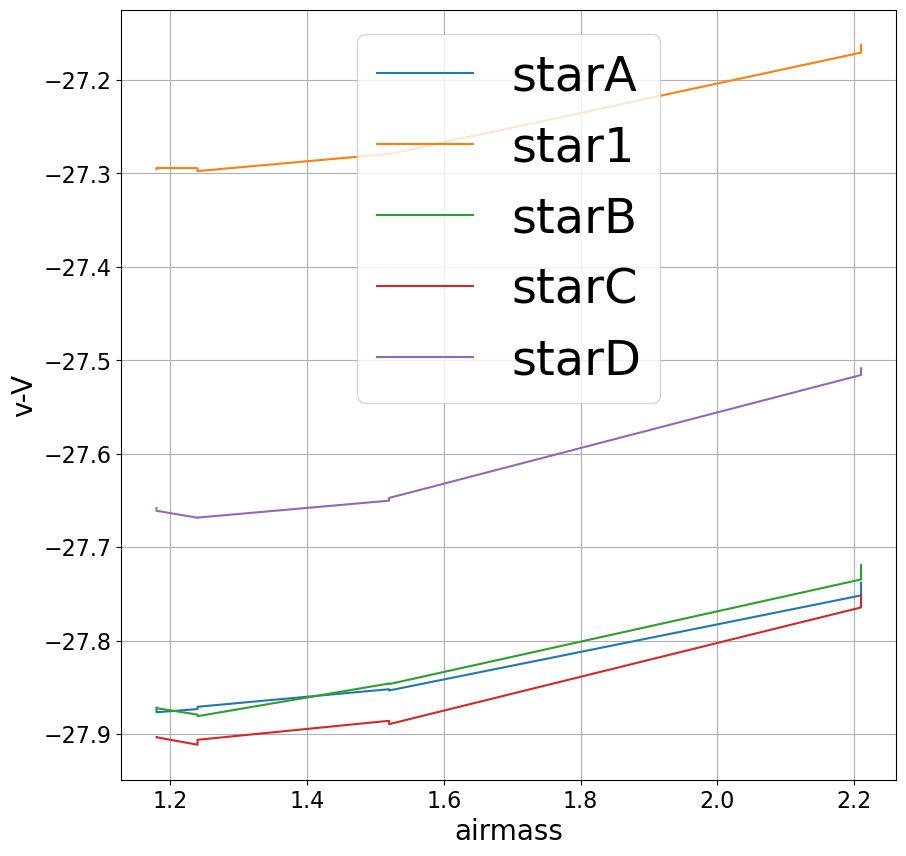

In [516]:
airmassesV = [1.18, 1.18, 1.24, 1.24, 1.52, 1.52, 2.21, 2.21]
print(goodA)
goodA = np.reshape(goodA, (-1, 8))
goodB = np.reshape(goodB, (-1, 8))
goodC = np.reshape(goodC, (-1, 8))
goodD = np.reshape(goodD, (-1, 8))
good1 = np.reshape(good1, (-1, 8))
print(goodA[0])

plt.plot(airmassesV, goodA[0], label='starA')
plt.plot(airmassesV, good1[0], label='star1')
plt.plot(airmassesV, goodB[0], label='starB')
plt.plot(airmassesV, goodC[0], label='starC')
plt.plot(airmassesV, goodD[0], label='starD')
plt.xlabel('airmass')
plt.ylabel('v-V')
leg = plt.legend()

## B-filter

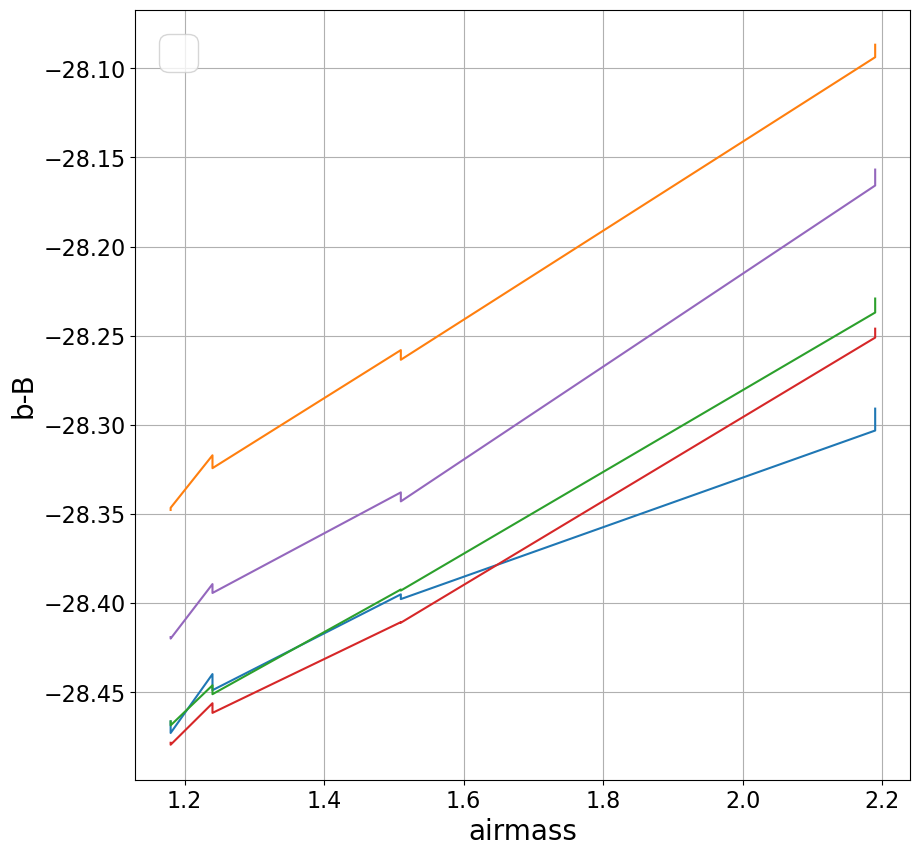

In [517]:
airmassesB = [1.18, 1.18, 1.24, 1.24, 1.51, 1.51, 2.19, 2.19]
plt.plot(airmassesB, goodA[1])
plt.plot(airmassesB, good1[1])
plt.plot(airmassesB, goodB[1])
plt.plot(airmassesB, goodC[1])
plt.plot(airmassesB, goodD[1])
plt.xlabel('airmass')
plt.ylabel('b-B')
leg = plt.legend()

## I-filter

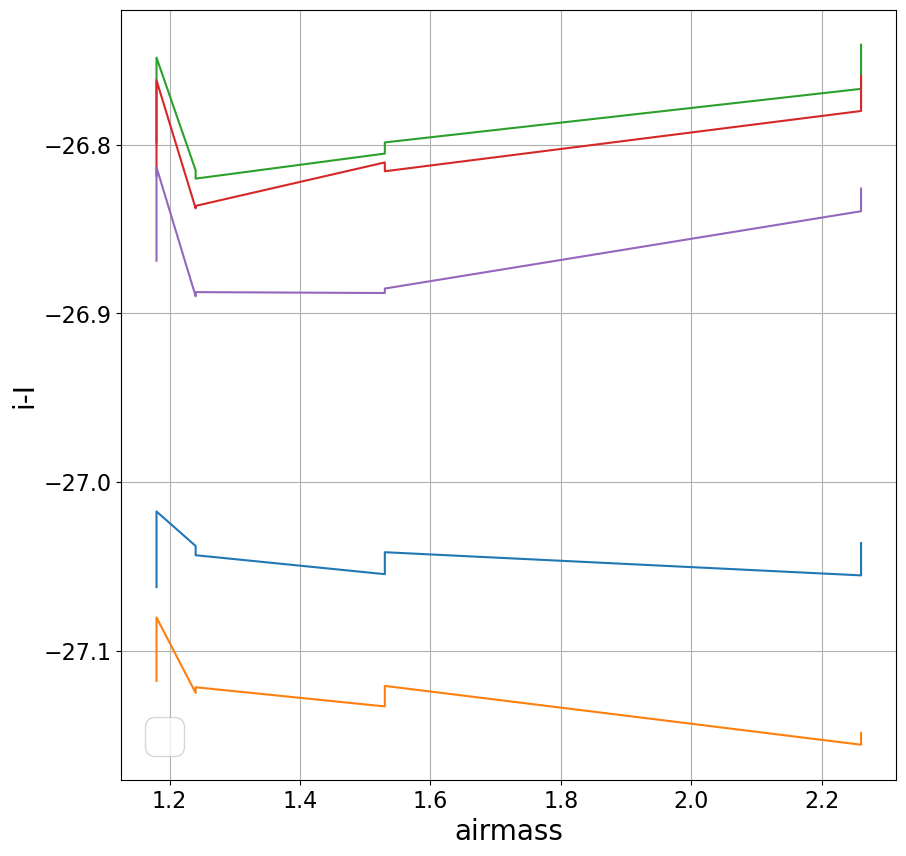

In [520]:
airmassesI = [1.18, 1.18, 1.24, 1.24, 1.53, 1.53, 2.26, 2.26]
plt.plot(airmassesI, goodA[2])
plt.plot(airmassesI, good1[2])
plt.plot(airmassesI, goodB[2])
plt.plot(airmassesI, goodC[2])
plt.plot(airmassesI, goodD[2])
plt.xlabel('airmass')
plt.ylabel('i-I')
leg = plt.legend()

## U-filter

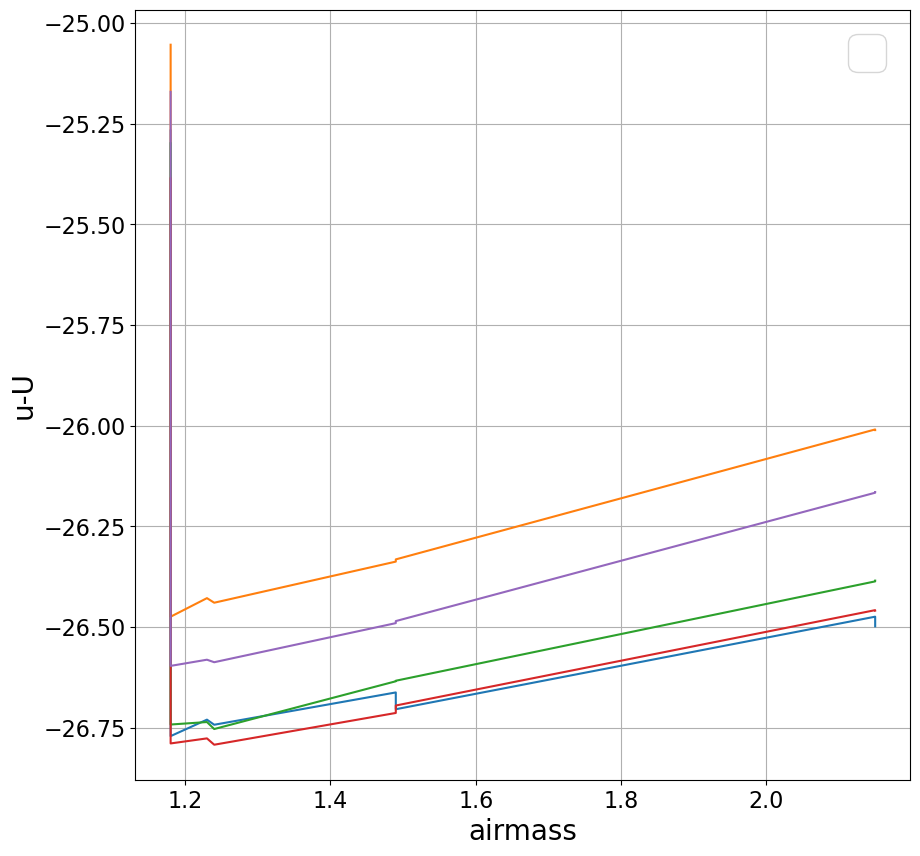

In [519]:
airmassesU = [1.18, 1.18, 1.23, 1.24, 1.49, 1.49, 2.15, 2.15]
plt.plot(airmassesU, goodA[3])
plt.plot(airmassesU, good1[3])
plt.plot(airmassesU, goodB[3])
plt.plot(airmassesU, goodC[3])
plt.plot(airmassesU, goodD[3])
plt.xlabel('airmass')
plt.ylabel('u-U')
leg = plt.legend()

## R-filter

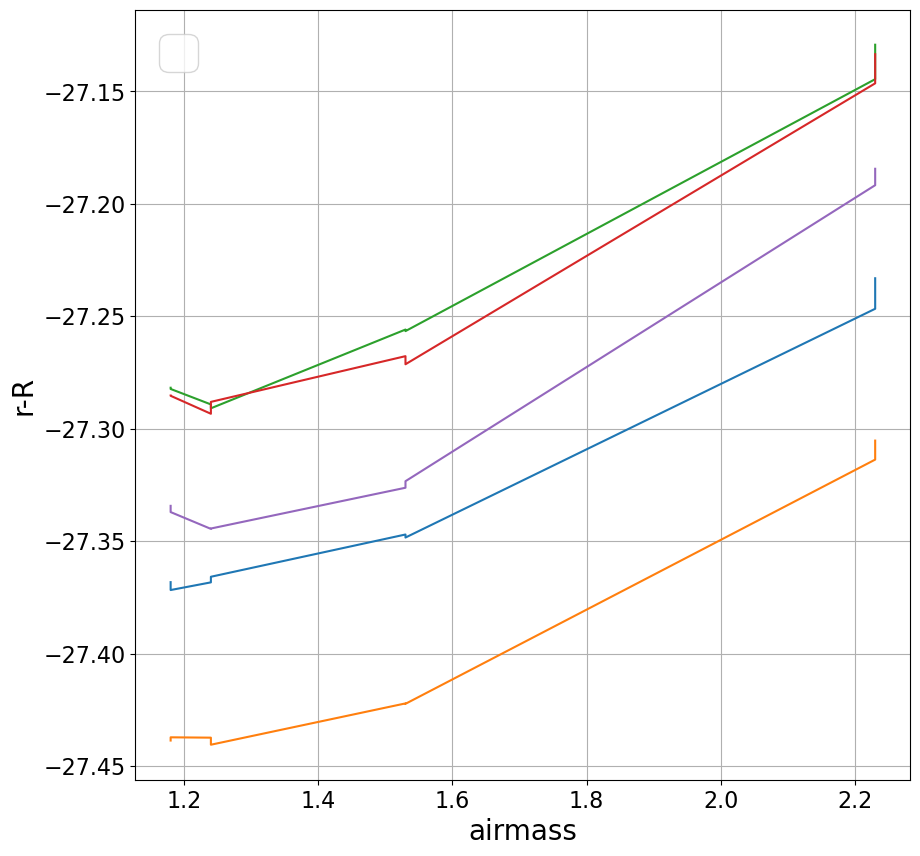

In [518]:
airmassesR = [1.18, 1.18, 1.24, 1.24, 1.53, 1.53, 2.23, 2.23]
plt.plot(airmassesR, goodA[4])
plt.plot(airmassesR, good1[4])
plt.plot(airmassesR, goodB[4])
plt.plot(airmassesR, goodC[4])
plt.plot(airmassesR, goodD[4])
plt.xlabel('airmass')
plt.ylabel('r-R')
leg = plt.legend()

Now we find the extinction coefficient using a linear least squares analysis by finding the slope of the line

In [429]:
goodAmag = np.vstack([goodA[0], np.ones(len(goodA[0]))]).T
kV, c = np.linalg.lstsq(goodAmag, airmassesV, rcond=None)[0]
print(kV)
goodBmag = np.vstack([goodA[1], np.ones(len(goodA[1]))]).T
kB, cB = np.linalg.lstsq(goodBmag, airmassesB, rcond=None)[0]
print(kB)
goodImag = np.vstack([goodA[2], np.ones(len(goodA[2]))]).T
kI, cI = np.linalg.lstsq(goodImag, airmassesI, rcond=None)[0]
print(kI)
goodUmag = np.vstack([goodA[3], np.ones(len(goodA[3]))]).T
kU, cU = np.linalg.lstsq(goodUmag, airmassesU, rcond=None)[0]
print(kU)
goodRmag = np.vstack([goodA[4], np.ones(len(goodA[4]))]).T
kR, cR = np.linalg.lstsq(goodRmag, airmassesR, rcond=None)[0]
print(kR)

7.528926904037809
6.013245146981651
-5.393089471294881
-0.09216159023954687
7.673862859996546


# Problem 6
Now that we have our extinction coefficients, we can correct our standard stars to zero airmass. Here I just use starA and correct it in the V, B, and R bands. Additionally, we find V-R and B-V colors

In [444]:
corrVa = (goodA[0]+15.256) - np.multiply(airmassesV,kV)
corrBa = (goodA[1]+16.093) - np.multiply(airmassesB,kB)
corrIa = goodA[2] - np.multiply(airmassesI,kI)
corrUa = goodA[3] - np.multiply(airmassesU,kU)
corrRa = (goodA[4]+14.751) - np.multiply(airmassesR,kR)
print(corrVa)

color1 = np.subtract(corrVa,corrRa)
color2 = np.subtract(corrBa,corrVa)

[-21.50139    -21.50489299 -21.95321915 -21.95072841 -24.04003268
 -24.04138441 -29.13462075 -29.12104751]


To find the zero point and first order color terms, we once again use a linear least squares analysis. The slope gives us our first order color term, and the y-intercept our zero point

0.0768509192960573 -28.039598244135334
0.09639722576529891 -28.656995263032467
-0.003352972425988954 -27.034625626494865
-0.08765989670756968 -26.248899602148462
0.07685091929605545 -27.534598244135335


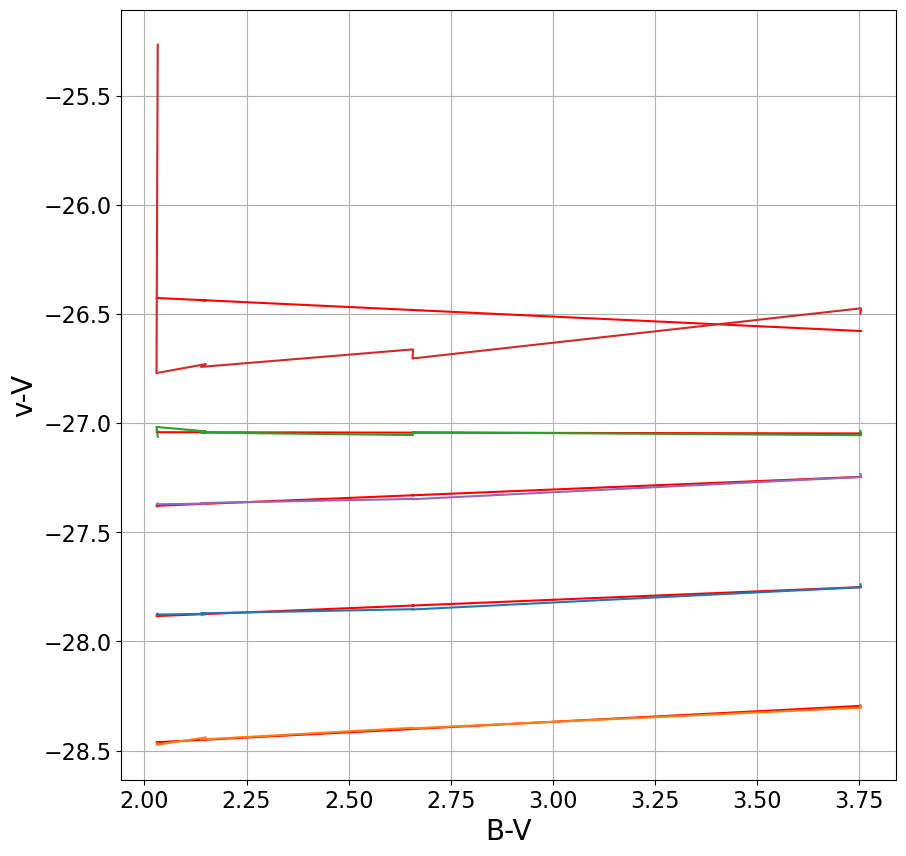

In [522]:
zp1 = [] #zeropoint
c01 = [] #first order color term
for i in np.arange(0,5):
    A = np.vstack([color2, np.ones(len(color2))]).T
    C, z = np.linalg.lstsq(A, goodA[i], rcond=None)[0]
    print(C,z)
    plt.plot(color2, C*color2 + z, 'r', label='Fitted line')
    plt.plot(color2, goodA[i])
    plt.xlabel('B-V')
    plt.ylabel('v-V')
    zp1 = np.append(zp1,z)
    c01 = np.append(c01, C)

0.42224202966634006 -27.95458308419854
0.5360535015637472 -28.552156915778863
-0.019997506120793075 -27.037893106897062
-0.4887299671454298 -26.3438811909882
0.4222420296663524 -27.449583084198544


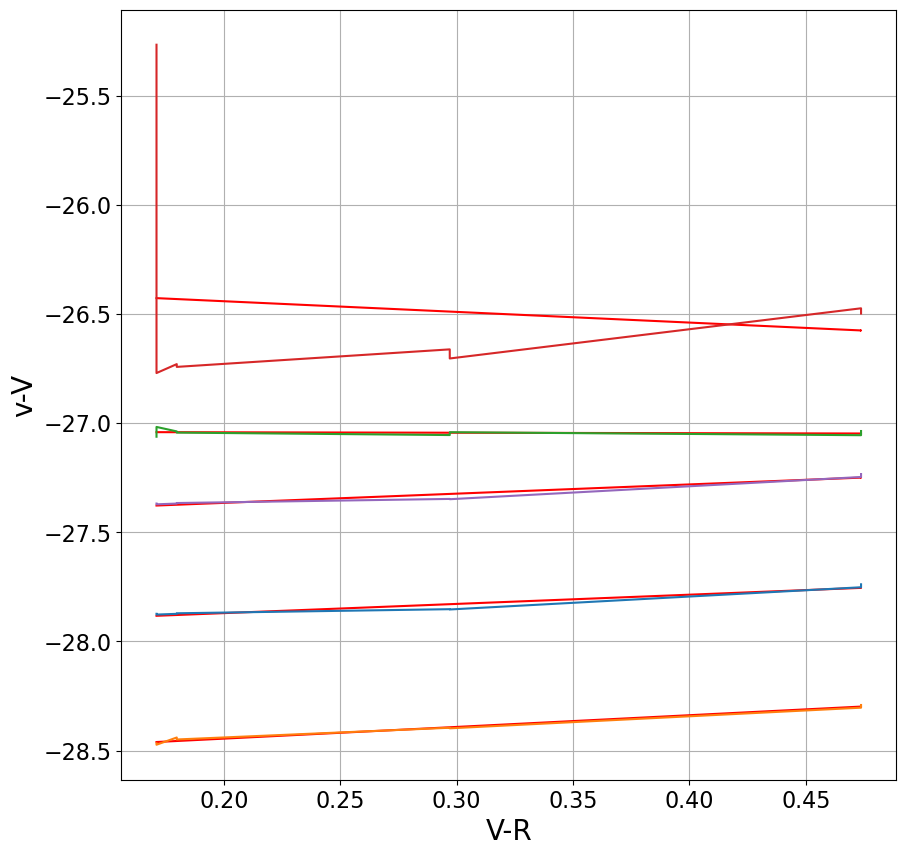

In [524]:
zp2 = [] #zeropoint
c02 = [] #first order color term
for i in np.arange(0,5):
    A = np.vstack([color1, np.ones(len(color1))]).T
    C, z = np.linalg.lstsq(A, goodA[i], rcond=None)[0]
    print(C,z)
    plt.plot(color1, C*color1 + z, 'r', label='Fitted line')
    plt.plot(color1, goodA[i])
    plt.xlabel('V-R')
    plt.ylabel('v-V')
    zp2 = np.append(zp2,z)
    c02 = np.append(c02, C)

We now make a table displaying the zero points and first order color terms in each filter, for each color

In [525]:
prob6 = Table()
prob6['Filter'] = ['V', 'B', 'I', 'U', 'R']
prob6['zero point V-R']   = zp1
prob6['first order color V-R'] = c01
prob6['zero point B-V']   = zp2
prob6['first order color B-V'] = c02


In [526]:
prob6

<Table length=5>
Filter    zero point V-R   ...    zero point B-V   first order color B-V
 str1        float64       ...       float64              float64       
------ ------------------- ... ------------------- ---------------------
     V -28.039598244135334 ...  -27.95458308419854   0.42224202966634006
     B -28.656995263032467 ... -28.552156915778863    0.5360535015637472
     I -27.034625626494865 ... -27.037893106897062 -0.019997506120793075
     U -26.248899602148462 ...   -26.3438811909882   -0.4887299671454298
     R -27.534598244135335 ... -27.449583084198544    0.4222420296663524

# Problem 7
We now want to make a V vs B-V plot of the stars in NGC6823. Using a different method than perviously done, I use DAOStarFinder to find each the star positions in both v and b bands

 ...]

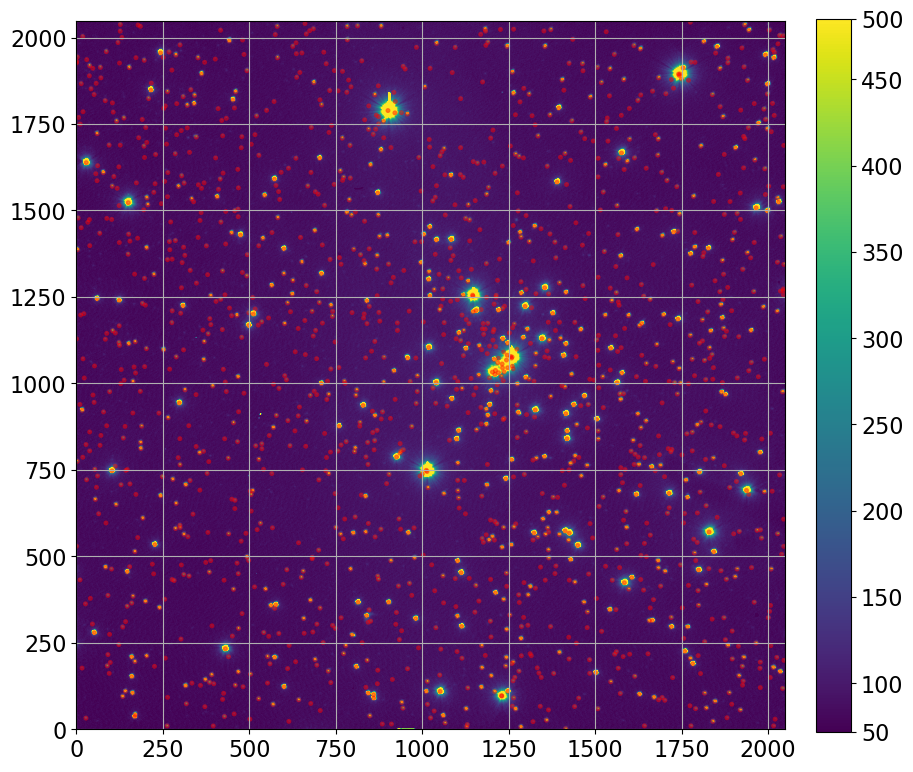

In [527]:
#7
#read in V filter data of NGC6823
hduNGCV = fits.open(reduced_dir+'a159ot.fits') #open .fits file
dataNGCv = hduNGCV[0].data
# find all stars in the frame satisfying the fwhm & threshold conditions
meanv, medianv, stdv = sigma_clipped_stats(dataNGCv, sigma=3.0)

daofindv = DAOStarFinder(fwhm=7.0, threshold=5.*stdv)   

sourcesv = daofindv(dataNGCv-medianv) 

p_v = np.transpose((sourcesv['xcentroid'],sourcesv['ycentroid']))

aperturesv = CircularAperture(p_v, r=4.)

show_image(dataNGCv)
aperturesv.plot(color='red', lw=1.5, alpha=0.5)

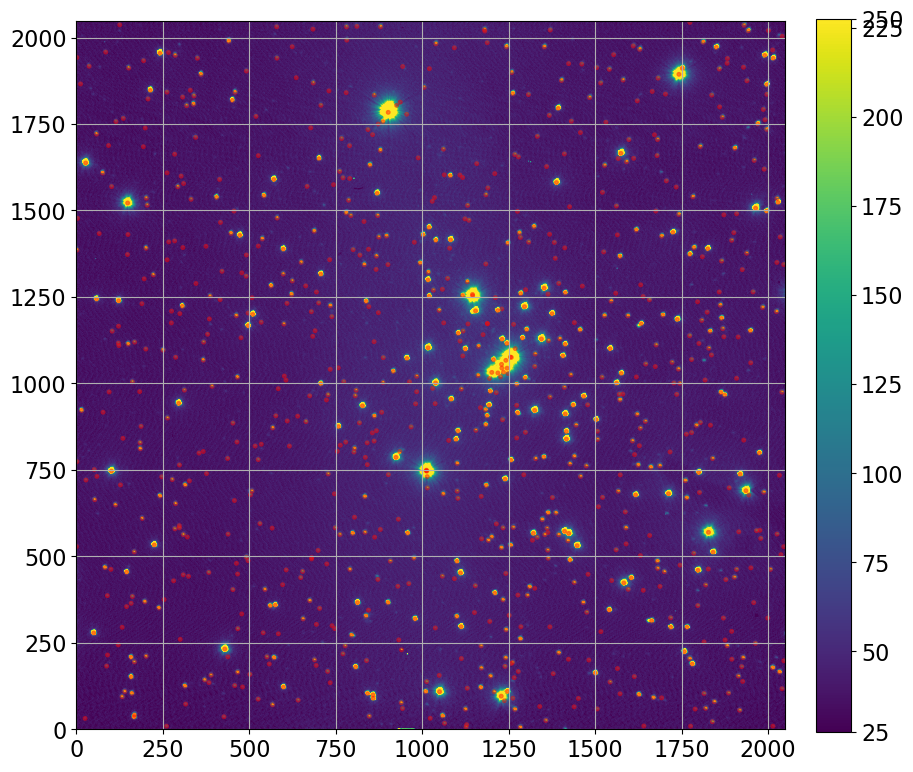

In [528]:
#read in B filter data of NGC6823
hduNGCB = fits.open(reduced_dir+'a160ot.fits') #open .fits file
dataNGCb = hduNGCB[0].data
# find all stars in the frame satisfying the fwhm & threshold conditions
meanb, medianb, stdb = sigma_clipped_stats(dataNGCb, sigma=3.0)

daofindb = DAOStarFinder(fwhm=7.0, threshold=5.*stdb)   

sourcesb = daofind2(dataNGCb-median2) 

p_b = np.transpose((sourcesb['xcentroid'],sourcesb['ycentroid']))

aperturesb = CircularAperture(p_b, r=4.)

show_image(dataNGCb)
aperturesb.plot(color='red', lw=1.5, alpha=0.5)

Now we do aperture photometry to obtain the v-band mags for the stars 

In [556]:
mag1 = []
for i in range(len(p_v)):
    annulus_aperturestandard = CircularAnnulus(p_v[i], r_in=10, r_out=15)
    aperturestandard = CircularAperture(p_v[i], r=7)
    phot_table = aperture_photometry(dataNGCv, aperturestandard) #aperture4 = 7pix
    phot_table['aperture_sum'].info.format = '%.8g'  # for consistent table output
    #print(phot_table)
    T = phot_table['aperture_sum'] #total counts in circular aperture
    #print(T)
    phot_table2 = aperture_photometry(dataNGCv, annulus_aperturestandard)
    phot_table2['aperture_sum'].info.format = '%.8g'  # for consistent table output
    #print(phot_table2)
    area = np.pi * 5**2 #area of circular aperture
    #print(area)
    areaannulus = np.pi*(15**2 - 10**2)
    #print(areaannulus)
    annuluscount = phot_table2['aperture_sum']
    B = annuluscount/areaannulus
    #print(B1)
    S = T - area*B
    #print(S)
    snr = S/B
    snr2 = np.sqrt(S)
    #print(snr2)
    m1 = -2.5*np.log10(S)
    #print(mI.data)
    m1data = m1.data
    mag1 = np.append(mag1, m1data)

C:\Users\azeem\AppData\Local\Temp\ipykernel_15388\1451841351.py:23: RuntimeWarning: invalid value encountered in sqrt
  snr2 = np.sqrt(S)
C:\Users\azeem\AppData\Local\Temp\ipykernel_15388\1451841351.py:25: RuntimeWarning: invalid value encountered in log10
  m1 = -2.5*np.log10(S)
C:\Users\azeem\AppData\Local\Temp\ipykernel_15388\1451841351.py:23: RuntimeWarning: invalid value encountered in sqrt
  snr2 = np.sqrt(S)
C:\Users\azeem\AppData\Local\Temp\ipykernel_15388\1451841351.py:25: RuntimeWarning: invalid value encountered in log10
  m1 = -2.5*np.log10(S)
C:\Users\azeem\AppData\Local\Temp\ipykernel_15388\1451841351.py:23: RuntimeWarning: invalid value encountered in sqrt
  snr2 = np.sqrt(S)
C:\Users\azeem\AppData\Local\Temp\ipykernel_15388\1451841351.py:25: RuntimeWarning: invalid value encountered in log10
  m1 = -2.5*np.log10(S)
C:\Users\azeem\AppData\Local\Temp\ipykernel_15388\1451841351.py:23: RuntimeWarning: invalid value encountered in sqrt
  snr2 = np.sqrt(S)
C:\Users\azeem\AppD

Repeat for the B-band

In [557]:
mag2 = []
for i in range(len(p_v)):
    annulus_aperturestandard = CircularAnnulus(p_v[i], r_in=10, r_out=15)
    aperturestandard = CircularAperture(p_v[i], r=7)
    phot_table = aperture_photometry(dataNGCb, aperturestandard) #aperture4 = 7pix
    phot_table['aperture_sum'].info.format = '%.8g'  # for consistent table output
    #print(phot_table)
    T = phot_table['aperture_sum'] #total counts in circular aperture
    #print(T)
    phot_table2 = aperture_photometry(dataNGCb, annulus_aperturestandard)
    phot_table2['aperture_sum'].info.format = '%.8g'  # for consistent table output
    #print(phot_table2)
    area = np.pi * 5**2 #area of circular aperture
    #print(area)
    areaannulus = np.pi*(15**2 - 10**2)
    #print(areaannulus)
    annuluscount = phot_table2['aperture_sum']
    B = annuluscount/areaannulus
    #print(B1)
    S = T - area*B
    #print(S)
    snr = S/B
    snr2 = np.sqrt(S)
    #print(snr2)
    m2 = -2.5*np.log10(S)
    #print(mI.data)
    m2data = m2.data
    mag2 = np.append(mag2, m2data)
print(mag2)

C:\Users\azeem\AppData\Local\Temp\ipykernel_15388\53988248.py:23: RuntimeWarning: invalid value encountered in sqrt
  snr2 = np.sqrt(S)
C:\Users\azeem\AppData\Local\Temp\ipykernel_15388\53988248.py:25: RuntimeWarning: invalid value encountered in log10
  m2 = -2.5*np.log10(S)
C:\Users\azeem\AppData\Local\Temp\ipykernel_15388\53988248.py:23: RuntimeWarning: invalid value encountered in sqrt
  snr2 = np.sqrt(S)
C:\Users\azeem\AppData\Local\Temp\ipykernel_15388\53988248.py:25: RuntimeWarning: invalid value encountered in log10
  m2 = -2.5*np.log10(S)
C:\Users\azeem\AppData\Local\Temp\ipykernel_15388\53988248.py:23: RuntimeWarning: invalid value encountered in sqrt
  snr2 = np.sqrt(S)
C:\Users\azeem\AppData\Local\Temp\ipykernel_15388\53988248.py:25: RuntimeWarning: invalid value encountered in log10
  m2 = -2.5*np.log10(S)
C:\Users\azeem\AppData\Local\Temp\ipykernel_15388\53988248.py:23: RuntimeWarning: invalid value encountered in sqrt
  snr2 = np.sqrt(S)
C:\Users\azeem\AppData\Local\Temp

[ -9.41492846 -10.79765566 -10.12661184 ...  -9.3439886   -9.08610078
  -9.37834446]


C:\Users\azeem\AppData\Local\Temp\ipykernel_15388\53988248.py:23: RuntimeWarning: invalid value encountered in sqrt
  snr2 = np.sqrt(S)
C:\Users\azeem\AppData\Local\Temp\ipykernel_15388\53988248.py:25: RuntimeWarning: invalid value encountered in log10
  m2 = -2.5*np.log10(S)
C:\Users\azeem\AppData\Local\Temp\ipykernel_15388\53988248.py:23: RuntimeWarning: invalid value encountered in sqrt
  snr2 = np.sqrt(S)
C:\Users\azeem\AppData\Local\Temp\ipykernel_15388\53988248.py:25: RuntimeWarning: invalid value encountered in log10
  m2 = -2.5*np.log10(S)


Now that we have our magnitudes we can correct for extinction, factor in the zero points and 1st order color terms, and find B-V

In [568]:
# both frames have the same airmass
airmass = 1.10

# correcting for atmospheric extinction
atm_ext_b = mag2-kB*airmass

atm_ext_v = mag1-kV*airmass

# zero points and 1st order color terms
stdb = atm_ext_b + zp2[1] + (c02[1])*bv    
stdv = atm_ext_v + zp2[2] + (c02[2])*bv
BV = stdb - stdv

[1.25630307 1.06311409 1.0780348  ... 1.09670222 0.98592494 1.15120386]


Text(0.5, 0, 'B-V')

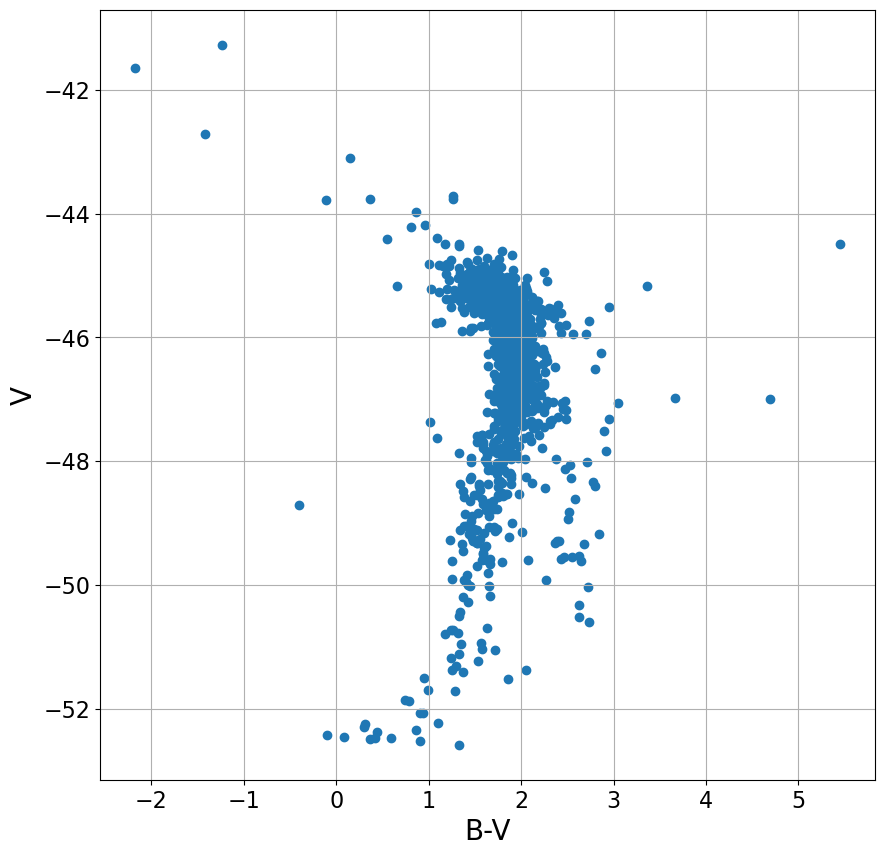

In [569]:
plt.scatter(BV, stdv)
plt.ylabel('V')
plt.xlabel('B-V')

The V band magnitude seems very very small here. I may have made a mistake when factoring in the accpeted magnitudes, or during my aperture photometry calculation. It also looks like it maybe upside down, perhaps due to a negative value somewhere.